# 0.0 Dependencies

**This notebook should run on any modern machine if the environment can**

1. run Jupyter/Python 
2. install the required packages 
3. write a local SQLite file
4. access the internet

**Strict requirements**

- *Python 3.9+* and a Jupyter runner (JupyterLab / Jupyter Notebook / VS Code notebooks)

Python packages: 

- requests
- pandas
- beautifulsoup4
- numpy
- matplotlib
- scikit-learn

- Ability to create/write DB_PATH = "overpass_recruiting.db" in the working directory (or change DB_PATH to a writable location)

- Internet access

**Other common portability gotchas:**

The cell !curl ... requires both shell ! support and curl installed. If missing, replace with a small Python requests.get(...) download.

init_db() uses if_exists="fail" which will error on re-runs if companies already exists. For repeatable runs, either delete the .db file before running or change to if_exists="replace".

Scraping results vary (rate limits, bot protection, timeouts, HTML changes). Start with small limit values.

## 0.1 Table of Contents
- [0.0 Dependencies](#0.0-Dependencies)
- [0.1 Table of Contents](#0.1-Table-of-Contents)
- [1.0 Overpass Recruiting](#1.0-Overpass-Recruiting:)
  - [1.1 Setup](#1.1-Setup)
  - [1.2 Query Overpass API](#1.2-Query-Overpass-API)
  - [1.3 Data Visualization](#1.3-Data-Visualization)
  - [1.4 Filter for companies with websites or contact info](#1.4-Filter-for-companies-with-websites-or-contact-info)
- [2.0 Scraping the web](#2.0-Scraping-the-web)
  - [2.1 Setup](#2.1-Setup)
  - [2.2 Queued Data Insertion (Companies)](#2.2-Queued-Data-Insertion-(Companies))
  - [2.3 Webscraper Helper Functions](#2.3-Webscraper-Helper-Functions)
  - [2.5 V Stands for Vector](#2.5-V-Stands-for-Vector)
- [3.0 Collecting Resume Data](#3.0-Collecting-Resume-Data)
  - [3.1 Setup](#3.1-Setup)
  - [3.2 User Handling](#3.2-User-Handling)
  - [3.3 Queued Data Insertion (Resumes)](#3.3-Queued-Data-Insertion-(Resumes))
  - [3.5 Vectorization](#3.5-Vectorization)
- [4.0 Data Visualization/Analysis](#4.0-Data-Visualization/Analysis)
  - [4.1 Setup](#4.1-Setup)
- [5.0 Project Discussion](#5.0-Project-Discussion)
  - [5.1 Future Directions](#5.1-Future-Directions)



# 1.0 Overpass Recruiting:
As an exercise in SQL, Pandas dataframes, data visualization, Numpy, and the broader analytical toolkit I've developed during my M.S. in Analytics program at Georgia Tech, this notebook seeks to answer relevant questions asked during most job searches, such as:

- What jobs are available near me?
- Are certain business types more prevalent in certain locations?
- How can I reach businesses near me?

## 1.1 Setup
The next code cell will import necessary libraries and establish the Overpass API. Overpass is OpenStreetMap's query service. You can think of it as an alternative to Google Maps. 

In [1]:
import requests
import re
import json
import sqlite3
from typing import List, Dict, Optional

import pandas as pd
from bs4 import BeautifulSoup
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from urllib.parse import urljoin, urlparse

OVERPASS_API = "https://overpass-api.de/api/interpreter"

## 1.2 Query Overpass API
The following functions will query the Overpass API using bounding box arguments around Minneapolis (The largest city in Minnesota). 

We first build our query using prerequesite information in build_overpass_query().

It is then passed to Overpass in fetch_osm_data() which returns our request information as a JSON.

Our final function, normalize_osm_results(), converts the JSON to a Pandas dataframe.

### build_overpass_query()
**Inputs:**
- bbox: A tuple representing cardinal direction information for the bounding box (south, west, north, east)
- name_filter: A string containing words we want included in the names of companies
- office_filter: A string containing words we want included in the names of office buildings

**Outputs:**
- query: A string containing the Overpass API query
---

### fetch_osm_data()
**Inputs:**
- query: A string containing the Overpass API query

**Outputs:**
- data: A dictionary containing the JSON response from the Overpass API
---

### normalize_osm_results()
**Inputs:**
- data: A dictionary containing the JSON response from the Overpass API
- city: An optional string labeling the city or area associated with the query

**Outputs:**
- df: A Pandas DataFrame where each row represents a company or office, including columns such as osm_type, osm_id, name, lat, lon, website, raw_tags, and city

In [2]:
# As a foreward, I'd like to apologize for my comments.
# I use CTRL + / to turn my regular text into comment form.
# The spacing is inconsistent because of this!

def build_overpass_query(
    bbox: tuple,
    name_filter: str,
    office_filter: str) -> str:

#     Organize cardinal directions into bounding box around city
    south, west, north, east = bbox
    
#     Define query such that we can filter for business/office names
    query = f"""
    [out:json][timeout:25];
    (
      node["office"~"{office_filter}"]["name"~"{name_filter}", i]({south},{west},{north},{east});
      way["office"~"{office_filter}"]["name"~"{name_filter}", i]({south},{west},{north},{east});
      relation["office"~"{office_filter}"]["name"~"{name_filter}", i]({south},{west},{north},{east});
    );
    out center tags;
    """
    
    return query.strip()


# Pass the query to the Overpass API! 
# You can research more for yourself here:
# https://wiki.openstreetmap.org/wiki/Overpass_API
# I'd highly recommend this resource.

def fetch_osm_data(query: str) -> Dict:
    response = requests.post(OVERPASS_API, data={"data": query})
    response.raise_for_status()
    return response.json()

def normalize_osm_results(data: Dict, city: Optional[str] = None) -> pd.DataFrame:
    
#     Overpass API returns information in JSON formatting
#     This function converts the JSON to a Pandas Dataframe
    
    records = []

    for el in data.get("elements", []):
        tags = el.get("tags", {})
        name = tags.get("name")
#         Skip nameless entries
        if not name:
            continue

#     Get coordinates (nodes have lat/lon; ways/relations use 'center')
#     Nodes and Ways are different types of 
        if "lat" in el and "lon" in el:
            lat = el["lat"]
            lon = el["lon"]
        else:
            center = el.get("center", {})
            lat = center.get("lat")
            lon = center.get("lon")
#     Skip places with no listed position 
#     (Sorry Dr. Who, we will not recruit for the Tardis)
        if lat is None or lon is None:
            continue

#     Extract contact info if present in tags
        website = tags.get("website") or tags.get("contact:website")
        email = tags.get("contact:email") or tags.get("email")
        phone = tags.get("contact:phone") or tags.get("phone")

        record = {
            "osm_type": el.get("type"),
            "osm_id": str(el.get("id")),
            "name": name,
            "lat": lat,
            "lon": lon,
            "website": website,
            "email": email,
            "phone": phone,
            "raw_tags": tags,
            "city": city,
        }
        records.append(record)

    df = pd.DataFrame(records)
    return df

Let's test our new functions! Input the cardinal info for Minneapolis and set city == "Minneapolis".

In [9]:
#bbox is defined as 44°58′55.20″ North, longitude 93°15′21.60″ West.
bbox_example = (44.88, -93.37, 45.05, -93.19)

query = build_overpass_query(bbox_example, name_filter="", office_filter="")
osm_json = fetch_osm_data(query)
companies_df = normalize_osm_results(osm_json, city="Minneapolis")

companies_df.head(10)

,osm_type,osm_id,name,lat,lon,website,email,phone,raw_tags,city
0,node,771701351,DCA Title,44.949382,-93.296433,None,None,None,"{'name': 'DCA Title', 'office': 'estate_agent'...",Minneapolis
1,node,771701483,Keller Williams Realty,44.949382,-93.296352,None,None,None,"{'brand': 'Keller Williams Realty', 'brand:wik...",Minneapolis
2,node,771701509,Rubicon Mortgage Advisors,44.949380,-93.296285,None,None,None,"{'addr:housenumber': '1300', 'addr:street': 'L...",Minneapolis
3,node,809362181,Land Stewardship Project,44.939256,-93.261710,https://landstewardshipproject.org/,None,None,"{'addr:city': 'Minneapolis', 'addr:housenumber...",Minneapolis
4,node,1020575360,Sterling Supply,44.994737,-93.221068,None,None,None,"{'name': 'Sterling Supply', 'office': 'company'}",Minneapolis
5,node,1077152564,Segway Tours,44.984534,-93.255170,None,None,+1-952-888-9200,"{'name': 'Segway Tours', 'office': 'guide', 'p...",Minneapolis
6,node,1077152731,Michael Sharp Realty,44.984567,-93.255243,None,None,None,"{'name': 'Michael Sharp Realty', 'office': 'es...",Minneapolis
7,node,1087602159,Sala Architects,44.988221,-93.255159,None,None,None,"{'addr:housenumber': '326', 'addr:street': 'Ea...",Minneapolis
8,node,1325895528,Seward Redesign,44.962604,-93.233435,None,None,None,"{'check_date': '2023-06-18', 'name': 'Seward R...",Minneapolis
9,node,1570464534,CodeWeavers Inc,44.961066,-93.196272,https://www.codeweavers.com/,sales@codeweavers.com,+1-651-523-9300,"{'addr:city': 'Saint Paul', 'addr:housenumber'...",Minneapolis


The above code cell should display a gorgeous dataframe populated with plenty of information. Dataframes aren't the most intuitive thing to look at, however. Using matplotlib, we can visualize the companies by their latitude and longitude!

## 1.3 Data Visualization

### preview_companies_scatter()
**Inputs:**
- df: A Pandas DataFrame containing company or office information, including latitude, longitude, and names
- bbox: A tuple representing the bounding box (south, west, north, east) used to set the axis limits
- name_col: A string naming the column in df that contains company names
- lat_col: A string naming the column in df that contains latitude values
- lon_col: A string naming the column in df that contains longitude values
- title: A string used as the title of the plot
- fig_width: A float specifying the width of the matplotlib figure in inches
- fig_height: A float specifying the height of the matplotlib figure in inches
- x_margin_frac: A float specifying the fraction of the longitude range to pad on each side of the x-axis

**Outputs:**
- plot: A matplotlib scatter plot rendered in the notebook showing company locations with text labels, using the provided bounding box and formatting

In [10]:
def preview_companies_scatter(
    df: pd.DataFrame,
    bbox,
    name_col: str = "name",
    lat_col: str = "lat",
    lon_col: str = "lon",
    title: str = "Company locations (Minneapolis)",
    fig_width: float = 10,
    fig_height: float = 8,
    x_margin_frac: float = 0.05):
    
    south, west, north, east = bbox

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # We can use NP arrays here for plotting
    x = np.asarray(df[lon_col].values)
    y = np.asarray(df[lat_col].values)

    ax.scatter(x, y, s=15, alpha=0.7)

    # Label our axes!
    for _, row in df.iterrows():
        lon = row[lon_col]
        lat = row[lat_col]

        if pd.isna(lon) or pd.isna(lat):
            continue

        name = str(row.get(name_col, ""))
        ax.text(
            lon,
            lat,
            name,
            fontsize=6,
            ha="left",
            va="bottom",
        )
    
    # Define range to plot
    x_range = east - west
    
    # Our margin is a little bit of extra space to make our graph look good
    x_margin = x_range * x_margin_frac

    ax.set_xlim(west - x_margin, east + x_margin)
    ax.set_ylim(south, north)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(title)

    # Format tick labels to 2 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

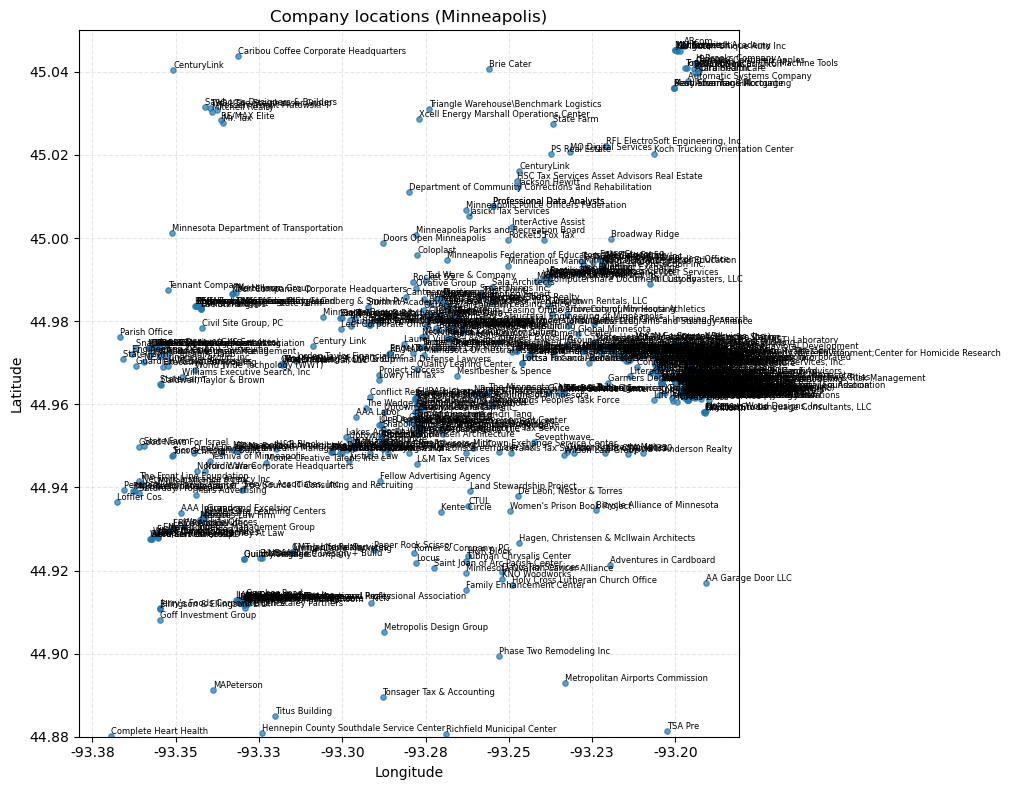

In [11]:
# Read it and weep for she is a beautiful graph (or he) (or they) (it?)
preview_companies_scatter(companies_df, bbox_example)

## 1.4 Filter for companies with websites or contact info

For the purposes of our program, we want to cycle through companies that have websites or contact information. Let's check how many of those there are!

In [12]:
columns_to_check = ['website', 'email', 'phone']

just_websites = ['website']

just_contact = ['email', 'phone']

reachable_companies_df = companies_df.dropna(how='all',
                                             subset=columns_to_check
                                             ).reset_index(drop=True)

web_companies_df = companies_df.dropna(how='all',
                                             subset=just_websites
                                             ).reset_index(drop=True)

contact_companies_df = companies_df.dropna(how='all',
                                             subset=just_contact
                                             ).reset_index(drop=True)

print(f"Total companies found: {len(companies_df)}")
print(f"With websites or contacts: {len(reachable_companies_df)}")
print(f"With just websites: {len(web_companies_df)}")
print(f"With just contacts: {len(contact_companies_df)}")

Total companies found: 558
With websites or contacts: 415
With just websites: 378
With just contacts: 344


If you've ran the above code cell, you should receive an output of: 

---

Total companies found: 549

With websites or contacts: 409

With websites: 373

With contacts: 341

---

What this means is that 409 companies have some information in the columns: 

['website', 'email', or 'phone'], but we don't always have all the information on hand.

Before attempting to solve this problem, let's visualize some of our results.

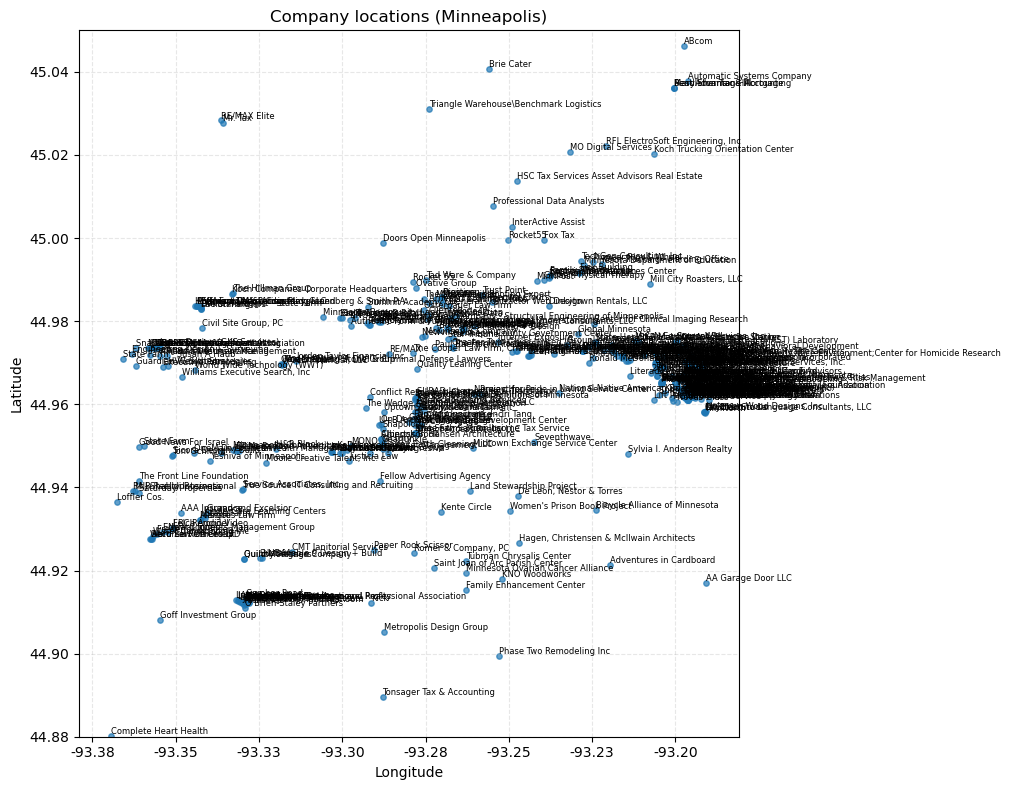

In [13]:
preview_companies_scatter(reachable_companies_df, bbox_example)

Here's an example of a company that would be excluded by our process, followed by one that would be retained.

In [14]:
example = companies_df.loc[companies_df['name'] == 'Caribou Coffee Corporate Headquarters']
example.head()

,osm_type,osm_id,name,lat,lon,website,email,phone,raw_tags,city
462,way,46581040,Caribou Coffee Corporate Headquarters,45.043873,-93.331231,None,None,None,"{'addr:city': 'Brooklyn Center', 'addr:housenu...",Minneapolis


In [15]:
example = companies_df.loc[companies_df['name'] == 'Brie Cater']
example.head()

,osm_type,osm_id,name,lat,lon,website,email,phone,raw_tags,city
38,node,4466287626,Brie Cater,45.040764,-93.256039,https://briecater.com/,None,+1-763-781-0702,"{'addr:city': 'Columbia Heights', 'addr:countr...",Minneapolis


After running the above code cell, you should see that the email field could be populated, if we were able to find it somewhere. It's use case for outreach should be apparent, but where could it possibly be?

Since the Overpass API does not return it, it's possible that the email address may be found on their website.

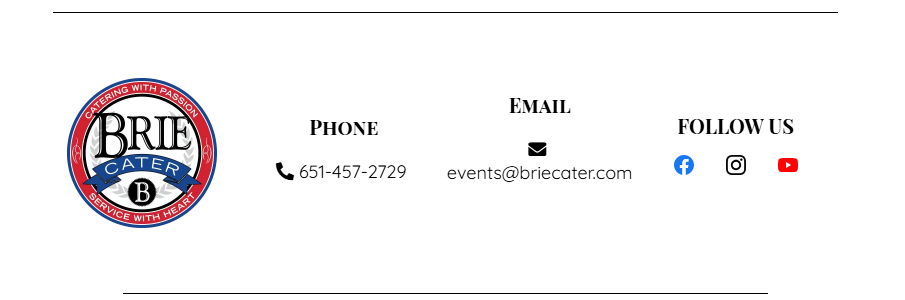

Surely enough, their contact information is present within their website. Furthermore, their phone number seems to be a more modern one! To me, this indicates that visiting each listing's website may be a crucial step in our outreach program. 

Doing so by hand would be extremely tedious, so we can turn to webscraping to complete this task!

# 2.0 Scraping the web 

For our next step, we'd like to fill in the blanks for emails and phone numbers. To do so, we'll be porting our dataframe over to SQL, such that webscraping agents can append the database with new information.

We also need to maintain the html of each website in some form, such that we can compare the sites later. We are making a few assumptions in doing so, namely, that the websites are representative of the businesses they're tied to. 

If we're operating on this chain of logic, the best solution seems to be vectorizing the html and storing it within our database. This encoding will enable our comparisons and be more storage efficient than keeping the html on hand.

Let's start with that SQL port!

## 2.1 Setup

Here, we'll define our SQL database location and initialize it. We're also going to cover some of our global variables and imports. Don't worry about most of them, just remember, we'll be using a Hashing Vectorizer.

In [16]:
from sklearn.feature_extraction.text import HashingVectorizer

HASH_VECTORIZER = HashingVectorizer(
    n_features=1024,    
    alternate_sign=False,
    norm='l2',
    stop_words='english',
)

DB_PATH = "overpass_recruiting.db"

# Sourced from www.regular-expressions.info/email.html.
EMAIL_REGEX = re.compile(
    r'\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b',
    re.IGNORECASE,)

PHONE_REGEX = re.compile(
    r'(?:\+?1[ \t.-]?)?' # Detects +1/1 prefix          
    r'(?:\(?\d{3}\)?[ \t.-]?'   # Detects area code
    r'\d{3}[ \t.-]?'       # Detects 3 digit section, I.E. 333-333
    r'\d{4})\b') # Detects 4 digit section, I.E. 4444

# Keywords to check for URL pathing. Contact info usually on one of these.
PATH_KWARGS = ['team', 'about', 'contact', 'company', 'help']

conn = sqlite3.connect(DB_PATH, timeout=30)
cursor = conn.cursor()
cursor.execute("""
    CREATE TABLE IF NOT EXISTS company_vectors (
        osm_id TEXT PRIMARY KEY,
        vector_json TEXT
    )
""")
conn.commit()
conn.close()

One consideration we have to make regarding our Pandas dataframe is that our ['raw_tags'] column is a dictionary! This works perfectly in Pandas (dictionaries are stored as objects), but SQL does not support dictionaries natively. We must therefore normalize the column. 

I chose to do so by coercing the information within ['raw_tags'] to JSON, or rather, by scanning through each column and coercing all dictionaries to JSON.

### tags_to_json()
**Inputs**
- df: A pandas dataframe

**Outputs**
- working_df: A pandas dataframe

For those unfamiliar, lambdas are anonymous functions. The lambda used here will first check if each value is a dictionary, then, it will coerce any dictionary to a JSON.

There is some optimization to be had, regarding checking .dtype. 

Unfortunately, the .dtype of these columns is 'object', not 'dict'.

Fortunately, that means we only have to search cols with .dtype == object!

In [17]:
def tags_to_json(df: pd.DataFrame) -> pd.DataFrame:
    working_df = df.copy()
    
    for col in working_df.columns:
        if working_df[col].dtype == "object":
            working_df[col] = working_df[col].apply(
                lambda val: json.dumps(val) if isinstance(val, dict) else val
            )
    return working_df

As an extra dose of silliness, after making our SQL from Pandas, we need to convert our SQL back to a Pandas dataframe to display it easily in text form. Here is a helper function to display our SQL DB, followed by a function to make our SQL database from our Pandas dataframe. ***Are you dizzy yet?***

## sql_head()
**Inputs**
- db_path: A string representing the file path for the SQLite database
- limit: An int representing the number of rows wanted

**Outputs**
- df: A pandas dataframe

In [18]:
def sql_head(db_path: str = DB_PATH, limit: int = 5) -> pd.DataFrame:
    conn = sqlite3.connect(db_path, timeout = 30)
    query = "SELECT * FROM companies LIMIT ?"
    df = pd.read_sql_query(query, conn, params=(limit,))
    conn.close()
    return df

Great! Now, back to the task at hand. Initializing the DB from Pandas -> SQL.

### init_db()
**Inputs:**
- df: A pandas dataframe
- db_path: A string representing the file path for the SQLite database

**Outputs:**
- None  
  - Side effect: Creates (if needed) a SQLite database file with a table that mirrors our DataFrame schema

In [19]:
def init_db(df: pd.DataFrame, db_path: str = DB_PATH) -> None:
    conn = sqlite3.connect(db_path, timeout = 30)
    df.to_sql("companies", conn, if_exists="fail", index=False)
    conn.close()
    print("Wrote DataFrame to SQLite 'companies' table (replaced existing data).")

Let's initialize our database using our Pandas dataframe **reachable_companies_df**! This should be an established variable. If not, check your copy of the code around exercise 1.4.

In [20]:
reachable_with_tags = tags_to_json(reachable_companies_df)
try:
    init_db(reachable_with_tags)
except Exception as e:
    print(e)

Table 'companies' already exists.


In [21]:
# Display our modified "reachable" Pandas dataframe
reachable_with_tags.head()

,osm_type,osm_id,name,lat,lon,website,email,phone,raw_tags,city
0,node,809362181,Land Stewardship Project,44.939256,-93.261710,https://landstewardshipproject.org/,None,None,"{""addr:city"": ""Minneapolis"", ""addr:housenumber...",Minneapolis
1,node,1077152564,Segway Tours,44.984534,-93.255170,None,None,+1-952-888-9200,"{""name"": ""Segway Tours"", ""office"": ""guide"", ""p...",Minneapolis
2,node,1570464534,CodeWeavers Inc,44.961066,-93.196272,https://www.codeweavers.com/,sales@codeweavers.com,+1-651-523-9300,"{""addr:city"": ""Saint Paul"", ""addr:housenumber""...",Minneapolis
3,node,1624631009,"Live Spark, Inc.",44.962101,-93.197407,http://www.live-spark.com/,info@live-spark.com,+1-651-289-7375,"{""addr:city"": ""Saint Paul"", ""addr:housenumber""...",Minneapolis
4,node,2071078928,Exosite,44.979840,-93.288413,https://exosite.com/,None,+1-612-353-2161,"{""addr:city"": ""Minneapolis"", ""addr:housenumber...",Minneapolis


In [22]:
# Display our brand new SQL dataframe
sql_head(DB_PATH)

,osm_type,osm_id,name,lat,lon,website,email,phone,raw_tags,city
0,node,809362181,Land Stewardship Project,44.939256,-93.261710,https://landstewardshipproject.org/,bdevore@landstewardshipproject.org,(320) 269-2105,"{""addr:city"": ""Minneapolis"", ""addr:housenumber...",Minneapolis
1,node,1077152564,Segway Tours,44.984534,-93.255170,None,None,+1-952-888-9200,"{""name"": ""Segway Tours"", ""office"": ""guide"", ""p...",Minneapolis
2,node,1570464534,CodeWeavers Inc,44.961066,-93.196272,https://www.codeweavers.com/,sales@codeweavers.com,+1-651-523-9300,"{""addr:city"": ""Saint Paul"", ""addr:housenumber""...",Minneapolis
3,node,1624631009,"Live Spark, Inc.",44.962101,-93.197407,http://www.live-spark.com/,info@live-spark.com,+1-651-289-7375,"{""addr:city"": ""Saint Paul"", ""addr:housenumber""...",Minneapolis
4,node,2071078928,Exosite,44.979840,-93.288413,https://exosite.com/,None,+1-612-353-2161,"{""addr:city"": ""Minneapolis"", ""addr:housenumber...",Minneapolis


## 2.2 Queued Data Insertion (Companies)
We can finally start populating the SQL database with new information from our webscrapers! First, we should select the columns that have a non-empty website with fields to populate.

For the sake of remaining in the 2 minute window given in this assignment, we'll limit this process to 5 entries and provide the fully populated database later.

Regarding complexity of our webscraper, we should develop in an agentic form. 

What I mean by that is, consider you were to send 1,000 requests from a single IP address or location to a single webserver. If it were a secure webserver, you would likely be blocked or penalized.

Thus, the webscraper must act as an independent agent that attempts to populate our database piecewise, but does not compromise our work if it fails. It must also be possible to run from many locations, asynchronous, and able to cooperate with other versions of the same webscraper in tandem.

This is because if both I (Tyler) and my friend John were attempting to run this webscraper at the same time, to avoid being banned from a website, we do not necessarily have control of the other person's webscraper.

To circumvent these issues, I have decided to append the raw_tags section of our database. We'll get to that later as well.

### select_companies()

**Inputs:**
- db_path: A string representing the file path for the SQLite database  
- limit: An int representing the maximum number of rows to retrieve

**Outputs:**
- targets: A pandas dataframe containing companies that:
  - have a website
  - are missing either email or phone
  - have not yet been marked with scraping tags

In [23]:
def select_companies(db_path: str = DB_PATH, limit: int = 5) -> pd.DataFrame:
    conn = sqlite3.connect(db_path, timeout = 30)
    query = """
        SELECT
            osm_id,
            name,
            website,
            email,
            phone,
            raw_tags
        FROM companies
        WHERE website IS NOT NULL
            AND website != ''
        LIMIT ?;    
    """
    targets = pd.read_sql_query(query, conn, params=(limit,))
    conn.close()
    return targets

Sick. Let's check out what we selected for our scraping queue.

In [24]:
to_scrape = select_companies(DB_PATH)
to_scrape

,osm_id,name,website,email,phone,raw_tags
0,809362181,Land Stewardship Project,https://landstewardshipproject.org/,bdevore@landstewardshipproject.org,(320) 269-2105,"{""addr:city"": ""Minneapolis"", ""addr:housenumber..."
1,1570464534,CodeWeavers Inc,https://www.codeweavers.com/,sales@codeweavers.com,+1-651-523-9300,"{""addr:city"": ""Saint Paul"", ""addr:housenumber""..."
2,1624631009,"Live Spark, Inc.",http://www.live-spark.com/,info@live-spark.com,+1-651-289-7375,"{""addr:city"": ""Saint Paul"", ""addr:housenumber""..."
3,2071078928,Exosite,https://exosite.com/,None,+1-612-353-2161,"{""addr:city"": ""Minneapolis"", ""addr:housenumber..."
4,2145976950,MinnPost,https://minnpost.com/,inn-member-badge@2x-130x85.jpg,0466488784,"{""addr:city"": ""Minneapolis"", ""addr:housenumber..."


## 2.3 Webscraper Helper Functions

Our webscraper will be composed of 4 main helper functions, designed to leverage the base Python libraries and BeautifulSoup4 to comb through retrieved html for emails and phone numbers.

scraping_file_system() is a bit of an outlier. Remember earlier when I mentioned that we want our program to support the capacity for multiple devices in multiple locations running the same program at once? scraping_file_system() updates our SQL database's `['raw_tags']` section to `scraping:reserved` immediately after queueing a listing for webscraping.

In theory, this should prevent our second device from completing the same work.

When finished, we'll update the `['raw_tags']` section to `scraping:complete`! 

### scraping_file_system()
**Inputs:**
- raw_tags_json: A string containing JSON tags (or None)  
- reserved_tag: A boolean for the scraping:reserved flag  
- completed_tag: A boolean for the scraping:complete flag

**Outputs:**
- json.dumps(tags): A JSON string representing the updated tags dictionary

In [25]:
def scraping_flag_system(raw_tags_json: str,
                         reserved_tag: bool,
                         completed_tag: bool) -> str:
    if not raw_tags_json:
        tags = {}
    else:
        try:
            tags = json.loads(raw_tags_json)
        except (TypeError, json.JSONDecodeError):
            tags = {}
            
    if reserved_tag:
        tags['scraping:reserved'] = True
    if completed_tag:
        tags['scraping:complete'] = True

    return json.dumps(tags)

These next few functions will help us grab and sort through the mess of html. grab_html() communicates a specific user agent to each website, with the hopes of receiving back the website's html.

### grab_html()
**Inputs:**
- url: A string containing the URL to fetch
- timeout: An integer specifying the maximum number of seconds to wait for a response

**Outputs:**
- html: A string containing the HTML content of the page, or None if the request fails or times out

In [26]:
def grab_html(url: str, timeout: int = 10) -> str:
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36"
    }
    
    try:
        resp = requests.get(url, headers=headers, timeout=timeout)
        resp.raise_for_status()
        return resp.text
    except Exception as e:
        print(f'[WARN] Failed to fetch {url}: {e}')
        return None

Assuming we receive some juicy html, and not an exception, our get_emails_and_num() function attempts to scan through the text file using regular expressions (or regex for short). If you're unfamiliar, regex are a type of search pattern that indicate when certain characters come up in strings. You can learn more at https://www.regex101.com.

### html_to_re_text()
**Inputs:**
- html: A string containing the HTML content of a page

**Outputs:**
- emails: A set of email address strings found within the HTML
- phones: A set of phone number strings found within the HTML

In [27]:
def html_to_re_text(html: str) -> (str, set, set):
    bs = BeautifulSoup(html, 'html.parser')
    text = bs.get_text(separator=' ', strip=True)
    text = re.sub(r'\s+', ' ', text).lower()
    
    emails = set(EMAIL_REGEX.findall(html))
    phones = set(PHONE_REGEX.findall(html))
    
    return text, emails, phones

Another key concern is that our webscraper may not always be able to skim contact information off the top. What if the website has all their information on an 'About' page? Our next function find_paths() uses urlparse to search all the hyperlinks on a website's mainpage, such that we can extend our search to those sites.

### find_paths()
**Inputs:**
- url: A string containing the base URL to crawl
- kwargs: A list of keyword strings used to filter “contact-like” paths (for example, team, about, contact, company, help); may be None
- timeout: An integer specifying the maximum number of seconds to wait when fetching each page

**Outputs:**
- candidate_urls: A list of same-domain URLs that either match one of the keyword strings in their path or, at minimum, include the base URL itself



In [28]:
def find_paths(url: str, kwargs: List[str] = None, timeout: int = 10) -> List[str]:
    html = grab_html(url, timeout)
    if not html:
        return []
    bs = BeautifulSoup(html, 'html.parser')
    url_parse = urlparse(url)
    network_location = url_parse.netloc.lower()
    
    candidate_urls = set()
    candidate_urls.add(url)
    
    if kwargs is None:
        return list(candidate_urls)
    
    # Find all hyperlinks within our html
    for link in bs.find_all('a', href=True):
        link_href = link['href'].lower()
        
        full_url = urljoin(url, link_href)
        parsed_link_url = urlparse(full_url)

        # Stay within the same domain
        if parsed_link_url.netloc and parsed_link_url.netloc.lower() != network_location:
            continue
        
        full_url_lower = full_url.lower()
        for keyword in kwargs:
            if keyword in full_url_lower:
                candidate_urls.add(full_url)
                break
                
    return list(candidate_urls)

Our next helper function serves to request the html of each derivative path from the source urls, before scraping them for emails and phone numbers.

### path_crawler()
**Inputs:**
- url: A string containing the base URL whose contact information we want to scrape
- kwargs: A list of keyword strings used by find_paths() to discover likely contact pages
- timeout: An integer specifying the maximum number of seconds to wait when fetching each page

**Outputs:**
- email_result: A single email string chosen from all candidates if any are found, otherwise None
- phone_result: A single phone number string chosen from all candidates if any are found, otherwise None

In [29]:
def path_crawler(url: str, kwargs: List[str], timeout: int = 10) -> (List[str], List[str]):
    contact_page_urls = find_paths(
        url,
        kwargs,
        timeout,
    )

    found_emails = set()
    found_phone_numbers = set()
    text_chunks = []

    for contact_page_url in contact_page_urls:
        page_html = grab_html(contact_page_url, timeout=timeout)
        if not page_html:
            continue

        page_text, email_candidates, phone_candidates = html_to_re_text(page_html)
        found_emails.update(email_candidates)
        found_phone_numbers.update(phone_candidates)
        if page_text:
            text_chunks.append(page_text)

    email_result = sorted(found_emails)[0] if found_emails else None
    phone_result = sorted(found_phone_numbers)[0] if found_phone_numbers else None

    site_text = ' '.join(text_chunks).strip()
    if site_text:
        vec_sparse = HASH_VECTORIZER.transform([site_text])
        vec_dense = vec_sparse.toarray().ravel()
        vector_list = [round(float(v), 4) for v in vec_dense]
    else:
        vector_list = None

    return email_result, phone_result, vector_list

What about those vector encodings I mentioned earlier? You may notice that we've built out a robust pipeline for collecting that email/phone information, but we haven't made much progress towards using the html for our clustering methods.

## 2.5 V Stands for Vector

Our vectorization model is a Hashing Vectorizer. This is essentially a stateless blackbox that will reproducibly convert our text corpus into a vector state. Learn more about them [here](https://www.youtube.com/watch?v=fCmaaFcibqI&t=415s&pp=ygUacHJvYmFibCBoYXNoaW5nIHZlY3Rvcml6ZXLSBwkJKQoBhyohjO8%3D), and our specific vectorizer [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html).

Therefore, the workflow follows the same pattern as our html retrieval agent. We just need to pass things through our vectorizer before we make database stores. 

Hopefully you can see how our pieces are really coming together. Just as a review, we've successfully used the Overpass API to gather a list of local businesses! To better fit our usecase, we're in the process of developing a webscraper that requests HTML from the URLs in our SQL database, and searches for emails and phone numbers using regex. We are attempting to do so agentically through editing the `['raw_tags']`.

This next function is the culmination of our data restructuring and helper function efforts.

### open_the_waygate()
**Inputs:**
- db_path: A string representing the file path for the SQLite database
- limit: An integer specifying how many company rows to process in this scraping pass
- timeout: An integer specifying the maximum number of seconds to wait when fetching each page
- kwargs: A list of keyword strings used to guide URL path selection when searching for contact pages

**Outputs:**
- export_df: A pandas DataFrame containing the `osm_id`, `name`, `email`, and `phone` for the batch of companies processed in this pass

In [30]:
def open_the_waygate(db_path: str = DB_PATH,
                     limit: int = 5,
                     timeout: int = 10,
                     kwargs: List[str] = None) -> pd.DataFrame:
    
    to_scrape = select_companies(db_path, limit)
    
    conn = sqlite3.connect(db_path, timeout=30)
    cursor = conn.cursor()
    
    for index, row in to_scrape.iterrows():
        raw_tags_json = row['raw_tags']
        scraping_tags = scraping_flag_system(
            raw_tags_json,
            reserved_tag=True,
            completed_tag=False,
        )
        cursor.execute(
            '''
            UPDATE companies
            SET raw_tags = ?
            WHERE osm_id = ?
            ''',
            (scraping_tags, row['osm_id']),
        )
        to_scrape.loc[index, 'raw_tags'] = scraping_tags
    
    conn.commit()
        
    for index, row in to_scrape.iterrows():
        website = row['website']
        if not isinstance(website, str) or not website.strip():
            continue

        scraped_email, scraped_phone, vector_list = path_crawler(
            website,
            kwargs,
            timeout=timeout,
        )

        final_email = row['email'] or scraped_email
        final_phone = row['phone'] or scraped_phone
        
        raw_tags_json = row['raw_tags']
        scraping_tags = scraping_flag_system(
            raw_tags_json, 
            reserved_tag=True,
            completed_tag=True,
        )

        if final_email is None and final_phone is None and vector_list is None:
            cursor.execute(
                '''
                UPDATE companies
                SET raw_tags = ?
                WHERE osm_id = ?
                ''',
                (scraping_tags, row['osm_id']),
            )
            to_scrape.loc[index, 'raw_tags'] = scraping_tags
            continue

        to_scrape.loc[index, 'email'] = final_email
        to_scrape.loc[index, 'phone'] = final_phone
        to_scrape.loc[index, 'raw_tags'] = scraping_tags

        cursor.execute(
            '''
            UPDATE companies
            SET email = ?, phone = ?, raw_tags = ?
            WHERE osm_id = ?
            ''',
            (final_email, final_phone, scraping_tags, row['osm_id']),
        )

        if vector_list is not None:
            vector_json = json.dumps(vector_list)
            cursor.execute(
                '''
                INSERT OR REPLACE INTO company_vectors (osm_id, vector_json)
                VALUES (?, ?)
                ''',
                (row['osm_id'], vector_json),
            )
        
    export_df = to_scrape[['osm_id', 'name', 'email', 'phone']].copy()
    
    conn.commit()
    conn.close()
    
    return export_df

In [31]:
open_the_waygate(DB_PATH, 5, 10, PATH_KWARGS)

,osm_id,name,email,phone
0,809362181,Land Stewardship Project,bdevore@landstewardshipproject.org,(320) 269-2105
1,1570464534,CodeWeavers Inc,sales@codeweavers.com,+1-651-523-9300
2,1624631009,"Live Spark, Inc.",info@live-spark.com,+1-651-289-7375
3,2071078928,Exosite,None,+1-612-353-2161
4,2145976950,MinnPost,inn-member-badge@2x-130x85.jpg,0466488784


In [32]:
open_the_waygate(DB_PATH, 5, 10, PATH_KWARGS)

,osm_id,name,email,phone
0,809362181,Land Stewardship Project,bdevore@landstewardshipproject.org,(320) 269-2105
1,1570464534,CodeWeavers Inc,sales@codeweavers.com,+1-651-523-9300
2,1624631009,"Live Spark, Inc.",info@live-spark.com,+1-651-289-7375
3,2071078928,Exosite,None,+1-612-353-2161
4,2145976950,MinnPost,inn-member-badge@2x-130x85.jpg,0466488784


In [33]:
open_the_waygate(DB_PATH, 400, 10, PATH_KWARGS)

[WARN] Failed to fetch https://www.seventhwave.org/: HTTPSConnectionPool(host='www.seventhwave.org', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000021469250F50>, 'Connection to www.seventhwave.org timed out. (connect timeout=10)'))
[WARN] Failed to fetch https://www.startribune.com/: 429 Client Error: Too Many Requests for url: https://www.startribune.com/
[WARN] Failed to fetch http://www.excelsiorongrand.com: HTTPConnectionPool(host='www.excelsiorongrand.com', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000214672DAC10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
[WARN] Failed to fetch https://www.adkoremegaforce.com;https://www.homicidecenter.org: HTTPSConnectionPool(host='www.adkoremegaforce.com;https', port=443): Max retries exceeded with url: //www.homicidecenter.org (Caused by NewConnectionEr

[WARN] Failed to fetch https://www.ativamed.com: 404 Client Error: Not Found for url: https://www.ativamed.com/
[WARN] Failed to fetch https://www.automatedlogic.com/en/company/branch-locations/: HTTPSConnectionPool(host='www.automatedlogic.com', port=443): Read timed out. (read timeout=10)
[WARN] Failed to fetch https://www.creativeimages.com: HTTPSConnectionPool(host='www.creativeimages.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1002)')))
[WARN] Failed to fetch https://www.digitalpictures.com/about.htm: 404 Client Error: Not Found for url: https://www.digitalpictures.com/about.htm
[WARN] Failed to fetch https://www.innovativeor.com: HTTPSConnectionPool(host='www.innovativeor.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000214686E4F50>: Failed to establis

[WARN] Failed to fetch https://www.coleharderinc.com/: HTTPSConnectionPool(host='www.coleharderinc.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000021468994050>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
[WARN] Failed to fetch https://www.juniperjustincase.com/: HTTPSConnectionPool(host='www.juniperjustincase.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000021468177290>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
[WARN] Failed to fetch https://parasole.com/: 403 Client Error: Forbidden for url: https://parasole.com/
[WARN] Failed to fetch https://aeglehealthpartners.com/: HTTPSConnectionPool(host='aeglehealthpartners.com', port=443): Max retries exceeded with url: / (Caused by SSLError(CertificateEr

,osm_id,name,email,phone
0,809362181,Land Stewardship Project,bdevore@landstewardshipproject.org,(320) 269-2105
1,1570464534,CodeWeavers Inc,sales@codeweavers.com,+1-651-523-9300
2,1624631009,"Live Spark, Inc.",info@live-spark.com,+1-651-289-7375
3,2071078928,Exosite,None,+1-612-353-2161
4,2145976950,MinnPost,inn-member-badge@2x-130x85.jpg,0466488784
...,...,...,...,...
370,1308879559,Sustainable 9 Design + Build,chadhanson@sustainable9.com,0190431169
371,1352475557,RE/MAX,None,+1-612-314-1520
372,1429555399,Triangle Warehouse\Benchmark Logistics,1eeb89147c984dc6bc3ffafd9e6cd089@sentry.wixpre...,+16516331612
373,13005933,Yeshiva of Minneapolis,yeshivaofminneapolis@gmail.com,+19529208673


Let's quickly visualize our databases!

In [34]:
def vector_head(db_path: str = DB_PATH, limit: int = 5) -> pd.DataFrame:
    conn = sqlite3.connect(db_path, timeout=30)
    query = """
        SELECT
            v.osm_id,
            c.name,
            v.vector_json
        FROM company_vectors AS v
        LEFT JOIN companies AS c
            ON v.osm_id = c.osm_id
        LIMIT ?;
    """
    df = pd.read_sql_query(query, conn, params=(limit,))
    conn.close()
    return df

In [35]:
# Check the company_vectors table!
vector_head(limit = 400)

,osm_id,name,vector_json
0,6267064934,Dynamic Fastener Services,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0142, 0.0, 0.1137,..."
1,6456665446,"Scott + Hespen Law, PLLC","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,7150081729,Hay Dobbs Architects,"[0.1748, 0.0, 0.0, 0.0087, 0.0087, 0.0, 0.0087..."
3,88464294,Justicia Law,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1042503165,Frederick & Rosen Ltd,"[0.0, 0.0, 0.0, 0.0079, 0.0, 0.1264, 0.0, 0.0,..."
...,...,...,...
304,1214437003,Mr. Tax,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0277, 0.0, 0...."
305,1308879559,Sustainable 9 Design + Build,"[0.0448, 0.0, 0.0, 0.0, 0.0, 0.0448, 0.0224, 0..."
306,1429555399,Triangle Warehouse\Benchmark Logistics,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0905, 0.0, 0...."
307,13005933,Yeshiva of Minneapolis,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0061, 0.0183, 0.00..."


In [36]:
# Check the companies table!
sql_head(DB_PATH)

,osm_type,osm_id,name,lat,lon,website,email,phone,raw_tags,city
0,node,809362181,Land Stewardship Project,44.939256,-93.261710,https://landstewardshipproject.org/,bdevore@landstewardshipproject.org,(320) 269-2105,"{""addr:city"": ""Minneapolis"", ""addr:housenumber...",Minneapolis
1,node,1077152564,Segway Tours,44.984534,-93.255170,None,None,+1-952-888-9200,"{""name"": ""Segway Tours"", ""office"": ""guide"", ""p...",Minneapolis
2,node,1570464534,CodeWeavers Inc,44.961066,-93.196272,https://www.codeweavers.com/,sales@codeweavers.com,+1-651-523-9300,"{""addr:city"": ""Saint Paul"", ""addr:housenumber""...",Minneapolis
3,node,1624631009,"Live Spark, Inc.",44.962101,-93.197407,http://www.live-spark.com/,info@live-spark.com,+1-651-289-7375,"{""addr:city"": ""Saint Paul"", ""addr:housenumber""...",Minneapolis
4,node,2071078928,Exosite,44.979840,-93.288413,https://exosite.com/,None,+1-612-353-2161,"{""addr:city"": ""Minneapolis"", ""addr:housenumber...",Minneapolis


# 3.0 Collecting Resume Data

As a quick reminder, we're aiming to compare user information to available company information. Since this is the case, we're also going to want to be able to store resume/user data, such that we can query it for semantic analysis. 

To do so, we'll first be creating and populating a SQL table named "resumes", modeling it after our "companies" table. Similarly, we'll also create a "resume_vectors" table after our "company_vectors" table. As a product, it would be important to also create a "user" table that would connect multiple resumes, but we'll hold off on that for now.

The data pipeline for resumes is largely the same as the company websites, but instead of processing html, we'll be processing .txt resume files. 

This resume dataset: https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset/data is also available for test data, but for this project, you can consider cleaning/fitting this data to be out of scope. 

## 3.1 Setup

Here we'll define our SQL Schema and import necessary libraries for scraping resumes!

The overall schemas for our resume tables are based off of our company tables, such that joining and scaling these tables will be intuitive in the future.

In [72]:
import os

# Used for hashing .txt files that we store within our SQL database
import hashlib

# For the sake of this notebook, we'll be using random to determine IDs
# In a product implementation, we would opt for using Google Account API
import random

# 200 kb cap for resume files
MAX_RESUME_BYTES = 200_000

# Create resume tables if they do not exist
conn = sqlite3.connect(DB_PATH, timeout=30)
cursor = conn.cursor()

# Users table: user-level metadata
cursor.execute('''
    CREATE TABLE IF NOT EXISTS users (
        user_id TEXT PRIMARY KEY,
        name TEXT,
        email TEXT,
        city TEXT,
        lat REAL,
        lon REAL,
        raw_tags TEXT
    )
''')

# Resumes table: one row per resume, linked to users.user_id
cursor.execute('''
    CREATE TABLE IF NOT EXISTS resumes (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        user_id TEXT NOT NULL,
        resume_hash TEXT NOT NULL,
        name TEXT,
        email TEXT,
        phone TEXT,
        raw_tags TEXT,
        UNIQUE(user_id, resume_hash)
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS resume_vectors (
        id INTEGER PRIMARY KEY,
        vector_json TEXT
    )
''')

conn.commit()
conn.close()

# Import datafiles

import zipfile
!curl -L -o Sample_Resumes.zip "https://github.com/WACKE127/overpass-recruiting/raw/main/Sample_Resumes.zip"

with zipfile.ZipFile("Sample_Resumes.zip", 'r') as zip_ref:
    zip_ref.extractall("Sample_Resumes")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  6302  100  6302    0     0  34485      0 --:--:-- --:--:-- --:--:-- 34485


## 3.2 User Handling

One of our primary concerns for handling users is understanding and processing their data in relation to their unique identification. As a complete product, this step would entail handling UI/UX of google sign ins. Within the scope of this project, we'll be developing a users table that contains user-level metadata that does not belong in the resume table. 

For this task, we'll be developing a helper function that appends our SQLite users table with proper user information.

### upsert_user()
**Inputs:**
- user_id: A unique string representing a user's ID
- name: A non-unique string representing a user's name
- email: A string representing a user's email address
- city: A string representing a user's city of interest
- lat: A float representing the coordinate latitude of a user
- lon: A float representing the coordinate longitude of a user
- raw_tags: A dictionary representing applicable keywords we can attach to a user
- db_path: A string representing the location of our SQLite DB

**Outputs:**
- NONE: Updates db @ db_path

In [73]:
def upsert_user(
    user_id: str,
    name: Optional[str] = None,
    email: Optional[str] = None,
    city: Optional[str] = None,
    lat: Optional[float] = None,
    lon: Optional[float] = None,
    raw_tags: Optional[Dict] = None,
    db_path: str = DB_PATH,) -> None:

    raw_tags_json = json.dumps(raw_tags) if isinstance(raw_tags, dict) else raw_tags

    conn = sqlite3.connect(db_path, timeout=30)
    cursor = conn.cursor()

    cursor.execute(
        """
        INSERT INTO users (user_id, name, email, city, lat, lon, raw_tags)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        ON CONFLICT(user_id) DO UPDATE SET
            name   = COALESCE(excluded.name,   users.name),
            email  = COALESCE(excluded.email,  users.email),
            city   = COALESCE(excluded.city,   users.city),
            lat    = COALESCE(excluded.lat,    users.lat),
            lon    = COALESCE(excluded.lon,    users.lon),
            raw_tags = COALESCE(excluded.raw_tags, users.raw_tags)
        """,
        (user_id, name, email, city, lat, lon, raw_tags_json),
    )

    conn.commit()
    conn.close()


## 3.3 Queued Data Insertion (Resumes)

In this section, we'll begin to insert a folder full of .txt files into our resume queue. Each file should represent a resume that has been preprocessed into plain text (outside of scope). There are, however, a few notable issues with this source of data. Namely, each resume:

- May contain noisy text

- May not contain contact information

- May be too long

Our job here is to read the .txt files and normalize contact information using the same regex from earlier when we were screening company websites. We will be storing this information in our new "resumes" SQL datatable.

When we developed our queued data insertion process for our companies, we already had a list of websites that we intended to visit and request the HTML from. Now that we're operating on local files, we'll instead be developing an agentic approach that uses independent user agents to catelogue local files in our database.

The way I like to think about it is: imagine that you have one central server for your many devices. All of the devices are attempting to upload information to this server at once, but, they are not guaranteed to succeed. To mitigate this problem, we can treat each user as an agent that queues their intent into the database. This enables every other user/agent to check where their position is, before they attempt to upload their own files.

Let's start with developing some helper functions to sanitize the raw input, generate hash data so we can uniquely identify resumes, and store both text and contact information within our database agentically.

### read_screen_and_hash()
**Inputs:**
- text_file_path: A string representing the file path for the txt file we're attempting to screen as a resume
- user_id: A string representing a user_id to store this file under in our SQLite db
- max_bytes: An integer pulled from the global variables, denoting the max size of a resume

**Outputs:**
- tuple of text.strip(), hasher.hexdigest(): A tuple containing the stripped .txt file, along with a hash representing the unique .txt file

In [74]:
def read_screen_and_hash(
    text_file_path: str,
    user_id: str,
    max_bytes: int = MAX_RESUME_BYTES,):
    
    # screen
    if not os.path.isfile(text_file_path):
        return None
    
    file_size = os.path.getsize(text_file_path)
    if file_size == 0 or file_size > max_bytes:
        return None

    with open(text_file_path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()

    if not text or not text.strip():
        return None
    
    # hash
    hasher = hashlib.sha256()
    hasher.update(user_id.encode('utf-8'))
    hasher.update(b'::')
    hasher.update(text.strip().encode('utf-8'))
    
    return (text.strip(), hasher.hexdigest())

### extract_resume_contact()
**Inputs:**
- text: A string representing a .txt resume obtained from text.strip() in read_screen_and_hash()

**Outputs:**
- email: A string representing the regex matches for our EMAIL_REGEX in the .txt file
- phone: A string representing the regex matches for our PHONE_REGEX in the .txt file

In [75]:
def extract_resume_contact(text: str):
    email_matches = EMAIL_REGEX.findall(text)
    phone_matches = PHONE_REGEX.findall(text)

    email = email_matches[0] if email_matches else None
    phone = phone_matches[0] if phone_matches else None

    return email, phone

## 3.5 Vectorization

In [76]:
def vectorize_resume_text(text: str) -> List[float]:
    vec = HASH_VECTORIZER.transform([text])
    dense = vec.toarray().ravel()
    return [round(float(v), 4) for v in dense]

### queue_resume_from_file()
**Inputs:**
- text_file_path: A string representing the file path for the txt file we're attempting to screen as a resume
- user_id: A string representing a user_id to store this file under in our SQLite db
- db_path: A string representing the file path for our SQLite DB

**Outputs:**
- None

In [77]:
def queue_resume_from_file(
    text_file_path: str,
    user_id: str,
    db_path: str = DB_PATH,) -> None:
    upsert_user(user_id=user_id, db_path=db_path)

    result = read_screen_and_hash(text_file_path, user_id=user_id)
    if result is None:
        return

    resume_text, resume_hash = result
    email, phone = extract_resume_contact(resume_text)

    base = os.path.basename(text_file_path)
    name = os.path.splitext(base)[0]

    raw_tags = json.dumps({
        "resume:source": "txt",
        "resume:length_chars": len(resume_text),
    })

    conn = sqlite3.connect(db_path, timeout=30)
    cursor = conn.cursor()

    cursor.execute(
        """
        INSERT OR IGNORE INTO resumes (
            user_id,
            resume_hash,
            name,
            email,
            phone,
            raw_tags
        )
        VALUES (?, ?, ?, ?, ?, ?)
        """,
        (user_id, resume_hash, name, email, phone, raw_tags),
    )

    cursor.execute(
        """
        SELECT id, name, email, phone
        FROM resumes
        WHERE user_id = ? AND resume_hash = ?
        """,
        (user_id, resume_hash),
    )
    row = cursor.fetchone()

    if row is None:
        conn.commit()
        conn.close()
        return

    resume_id, stored_name, stored_email, stored_phone = row

    new_email = stored_email or email
    new_phone = stored_phone or phone

    if new_email != stored_email or new_phone != stored_phone:
        cursor.execute(
            """
            UPDATE resumes
            SET email = ?, phone = ?
            WHERE id = ?
            """,
            (new_email, new_phone, resume_id),
        )

    # Vectorization step: single source of truth via HASH_VECTORIZER.
    vector_list = vectorize_resume_text(resume_text)
    vector_json = json.dumps(vector_list)

    cursor.execute(
        """
        INSERT OR REPLACE INTO resume_vectors (id, vector_json)
        VALUES (?, ?)
        """,
        (resume_id, vector_json),
    )

    conn.commit()
    conn.close()


### queue_resumes_in_folder()
**Inputs:**
- folder_path: A string representing the folder path for the txt files we're attempting to screen as resumes
- user_id: A string representing a user_id to store this file under in our SQLite db
- db_path: A string representing the file path for our SQLite DB

**Outputs:**
- None

In [78]:
def queue_resumes_in_folder(
    folder_path: str,
    user_id: str,
    db_path: str = DB_PATH,) -> None:
    
    for file_name in os.listdir(folder_path):
        if not file_name.lower().endswith(".txt"):
            continue

        text_file_path = os.path.join(folder_path, file_name)
        queue_resume_from_file(text_file_path, user_id=user_id, db_path=db_path)

In [79]:
demo_user_id = "tyler_wacker_minneapolis"

upsert_user(
    user_id=demo_user_id,
    name="Tyler Wacker",
    email=None,     # or your email if you want
    city="Minneapolis",
    lat=44.9778,
    lon=-93.2650,
)

queue_resumes_in_folder("Sample_Resumes/Sample_Resumes", user_id=demo_user_id)

### users_head()
**Inputs:**
- db_path: A string representing the file path for our SQLite DB
- limit: An integer representing the amount of users to show in the head function

**Outputs:**
- df: A pandas dataframe containing a certain amount of users

In [80]:
def users_head(db_path: str = DB_PATH, limit: int = 5) -> pd.DataFrame:
    conn = sqlite3.connect(db_path, timeout=30)
    query = "SELECT * FROM users LIMIT ?"
    df = pd.read_sql_query(query, conn, params=(limit,))
    conn.close()
    return df

### resumes_head()
**Inputs:**
- db_path: A string representing the file path for our SQLite DB
- limit: An integer representing the amount of resumes to show in the head function

**Outputs:**
- df: A pandas dataframe containing a certain amount of resumes

In [81]:
def resumes_head(db_path: str = DB_PATH, limit: int = 5) -> pd.DataFrame:
    conn = sqlite3.connect(db_path, timeout=30)
    query = "SELECT * FROM resumes LIMIT ?"
    df = pd.read_sql_query(query, conn, params=(limit,))
    conn.close()
    return df

### resume_vectors_head()
**Inputs:**
- db_path: A string representing the file path for our SQLite DB
- limit: An integer representing the amount of resume vectors to show in the head function

**Outputs:**
- df: A pandas dataframe containing a certain amount of resume vectors

In [82]:
def resume_vectors_head(db_path: str = DB_PATH, limit: int = 5) -> pd.DataFrame:
    conn = sqlite3.connect(db_path, timeout=30)
    query = "SELECT * FROM resume_vectors LIMIT ?"
    df = pd.read_sql_query(query, conn, params=(limit,))
    conn.close()
    return df

In [83]:
users_head(DB_PATH, limit=10)

,user_id,name,email,city,lat,lon,raw_tags
0,tyler_wacker_minneapolis,Tyler Wacker,None,Minneapolis,44.9778,-93.265,None


In [84]:
resumes_head(DB_PATH, limit=10)

,id,user_id,resume_hash,name,email,phone,raw_tags
0,1,tyler_wacker_minneapolis,e7b73cdfbb6c27ad910cf1da7b72572009e9245970c975...,C Berger,ber00067@umn.edu,6123252857,"{""resume:source"": ""txt"", ""resume:length_chars""..."
1,2,tyler_wacker_minneapolis,54e78a4daa33deedcc417b0a004898ea0d277d6e686f8a...,K Wacker,SANDEVIRAE.ILLO@GMAIL.COM,(612) 412-6526,"{""resume:source"": ""txt"", ""resume:length_chars""..."
2,3,tyler_wacker_minneapolis,76a7bb25777aedcf1833aca6eddc8dab39b941b1667aab...,Wacker_Resume_Q4_2025 (1),tjwac27@gmail.com,952-999-2436,"{""resume:source"": ""txt"", ""resume:length_chars""..."
3,8,tyler_wacker_minneapolis,200016192950824421b425891dcdd0a2e6e0237c1868db...,C Henkels,chrishenkels03@gmail.com,612-718-8423,"{""resume:source"": ""txt"", ""resume:length_chars""..."


In [85]:
resume_vectors_head(DB_PATH, limit=10)

,id,vector_json
0,1,"[0.0, 0.0, 0.0, 0.0407, 0.0, 0.0, 0.0, 0.0, 0...."
1,2,"[0.1041, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,3,"[0.0355, 0.0, 0.0, 0.0355, 0.0, 0.0, 0.0355, 0..."
3,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 4.0 Data Visualization/Analysis

Let's first start by reviewing the information we have on hand.

Our notebook has successfully created 4 SQLite tables within our SQLite database. These are: 

### 1. companies (as c)
- osm_type (str)
- osm_id (int)
- name (str)
- lat (float)
- lon (float)
- website (str)
- email (str)
- phone (str)
- raw_tags (dict)
- city (str)
### 2. company_vectors (as cv)
- osm_id (int)
- vector_json (str)
### 3. users (as u)
- user_id (str)
- name (str)
- email (str)
- city (str)
- lat (float)
- lon (float)
- raw_tags (dict) 
### 4. resumes (as r)
- id (int)
- user_id (str)
- resume_hash (str)
- name (str)
- email (str)
- phone (str)
- raw_tags (dict)
### 5. resume_vectors (as rv)
- id (int)
- vector_json (str)

From here, hopefully the possible visualizations and analytics we can perform will ellucidate themselves.

By joining the 'companies' and 'company_vectors' tables, we should have all the necessary information to plot businesses based on:
- c.osm_id, c.name, c.lat, c.lon, cv.vector_json

This pairing will allow us to see how business sectors are approximately divided based on our semantic vectorization.

## 4.1 Setup

In this section, we'll be developing a 3D plot based on Principal Component Analysis to develop charts that show how 'similar' a resume vector is to neighboring company vectors. 

The general idea is that if we can dilute the vectors down to three principal components, or in more general terms, discover which three features are most responsible for the differences between our data points, we should be able to see how close our data points are to each other in a three dimensional diagram.

To do so, we'll be importing PCA from scikit learn, and using MatPlotLib to generate our 3d graphs.

In [104]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed to register 3D projection

### load_resume_vector()
**Inputs:**
- conn: A SQLite Connection
- user_id: An integer representing the user_id from the 'users' table
- resume_id: An integer representing the resume_id from the 'resumes' table

**Outputs:**
- tuple: (resume_id (int), vector)

In [120]:
def load_resume_vector(
    conn: sqlite3.Connection,
    user_id: str,
    resume_id: int,
) -> tuple[int, np.ndarray]:
    cursor = conn.cursor()
    cursor.execute(
        """
        SELECT rv.id, rv.vector_json
        FROM resume_vectors AS rv
        JOIN resumes AS r
            ON rv.id = r.id
        WHERE r.user_id = ?
          AND r.id = ?
        """,
        (user_id, resume_id),
    )

    row = cursor.fetchone()
    if row is None:
        raise ValueError(
            f"No resume vector found for user_id={user_id!r} and resume_id={resume_id}."
        )

    rid, vector_json = row
    vec = np.asarray(json.loads(vector_json), dtype=float)
    return rid, vec


### load_company_vectors_with_metadata
**Inputs:**
- conn: A SQLite Connection

**Outputs:**
- pandas_dataframe: A dataframe containing a left joined vector and company tables on osm_id

In [121]:
def load_company_vectors_with_metadata(
    conn: sqlite3.Connection,
) -> pd.DataFrame:
    query = """
        SELECT
            v.osm_id,
            v.vector_json,
            c.name,
            c.city,
            c.lat,
            c.lon,
            c.website,
            c.email,
            c.phone
        FROM company_vectors AS v
        LEFT JOIN companies AS c
            ON v.osm_id = c.osm_id
    """
    df = pd.read_sql_query(query, conn)
    if df.empty:
        raise ValueError("No company vectors found in company_vectors table.")

    return df

### cosine_similarity_matrix()
**Inputs:**
- resume_vec: A numpy array representing a resume's vector
- company_vecs: A numpy array representing company vectors

**Outputs:**
- numpy array: A numpy array representing the result of a cosine similarity calculation

In [126]:
def cosine_similarity_matrix(
    resume_vec: np.ndarray,
    company_vecs: np.ndarray,) -> np.ndarray:
    
    # (n_features,) -> (n_features, 1) for broadcasting if desired
    resume_norm = np.linalg.norm(resume_vec)
    company_norms = np.linalg.norm(company_vecs, axis=1)

    denom = resume_norm * company_norms
    # Avoid division-by-zero
    denom[denom == 0] = 1e-12

    dots = company_vecs @ resume_vec
    return dots / denom


### visualize_resume_vs_companies
Honestly, this last visualization step is entirely AI generated. Since I'm going to be redefining most of this project, and this is just a temporarily prototyped solution that has no impact on the actual logic driving my decisions, there's really no need to compose a large writeup for its functionality.

I'm leaving the AI made comments within the function. It should be legible and understandable, as it follows the goals outlined earlier.

In [127]:
def visualize_resume_vs_companies(
    resume_id: Optional[int] = None,
    user_id: Optional[str] = None,
    top_k: int = 10,
    db_path: str = DB_PATH,
) -> pd.DataFrame:
    """
    Compare a selected resume to all company website vectors.

    This function:
      1. Selects a resume vector (by resume_id, user_id, or latest).
      2. Computes cosine similarity to all companies.
      3. Runs PCA to project everything into 3D.
      4. Plots a 3D scatter of companies + the chosen resume.
      5. Returns a top_k DataFrame of the most similar companies.

    Parameters
    ----------
    resume_id : int, optional
        Specific resume_vectors.id to use.
    user_id : str, optional
        If resume_id is not given, use the most recent resume for this user.
    top_k : int, default 10
        Number of top companies to return.
    db_path : str, default DB_PATH
        Path to the SQLite database.

    Returns
    -------
    pd.DataFrame
        Columns:
        ['osm_id', 'name', 'city', 'lat', 'lon',
         'website', 'email', 'phone', 'similarity']
        sorted by similarity (descending).
    """
    conn = sqlite3.connect(db_path, timeout=30)

    try:
        # 1. Select resume vector
        sel_resume_id, resume_vec = load_resume_vector(
            conn, 
            user_id=user_id, 
            resume_id=resume_id)
        # 2. Load company vectors + metadata
        comp_df = load_company_vectors_with_metadata(conn)

        # Parse JSON vectors into a matrix
        company_vectors = []
        valid_indices = []

        for idx, row in comp_df.iterrows():
            try:
                vec_list = json.loads(row["vector_json"])
                vec = np.asarray(vec_list, dtype=float)
                company_vectors.append(vec)
                valid_indices.append(idx)
            except Exception:
                # Skip rows with bad JSON
                continue

        if not company_vectors:
            raise ValueError("No valid company vectors could be parsed from vector_json.")

        company_vec_mat = np.vstack(company_vectors)

        # Restrict comp_df to the rows with valid vectors
        comp_df = comp_df.loc[valid_indices].reset_index(drop=True)

        # 3. Cosine similarity
        similarities = cosine_similarity_matrix(resume_vec, company_vec_mat)
        comp_df["similarity"] = similarities

        # 4. Top-k companies
        comp_df_sorted = comp_df.sort_values("similarity", ascending=False).reset_index(drop=True)
        top_k_df = comp_df_sorted.head(top_k)[
            ["osm_id", "name", "city", "lat", "lon", "website", "email", "phone", "similarity"]
        ]

        # 5. PCA to 3D for all companies + the resume
        all_vecs = np.vstack([company_vec_mat, resume_vec.reshape(1, -1)])
        pca = PCA(n_components=3)
        proj = pca.fit_transform(all_vecs)

        company_proj = proj[:-1]
        resume_proj = proj[-1]

        # Indices of top-k within comp_df
        top_k_indices = top_k_df.index.to_numpy()

        # 3D Plot
        fig = plt.subplots(figsize=(10, 8))[0]
        ax = fig.add_subplot(111, projection="3d")

        # All companies
        ax.scatter(
            company_proj[:, 0],
            company_proj[:, 1],
            company_proj[:, 2],
            s=15,
            alpha=0.2,
            label="All companies",
        )

        # Top-k companies
        ax.scatter(
            company_proj[top_k_indices, 0],
            company_proj[top_k_indices, 1],
            company_proj[top_k_indices, 2],
            s=40,
            alpha=0.9,
            label=f"Top {top_k} companies",
        )

        # Selected resume
        ax.scatter(
            resume_proj[0],
            resume_proj[1],
            resume_proj[2],
            s=80,
            marker="*",
            label=f"Resume {sel_resume_id}",
        )

        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("Resume vs. Company Website Vectors (3D PCA View)")
        ax.legend()
        plt.tight_layout()
        plt.show()

    finally:
        conn.close()

    return top_k_df

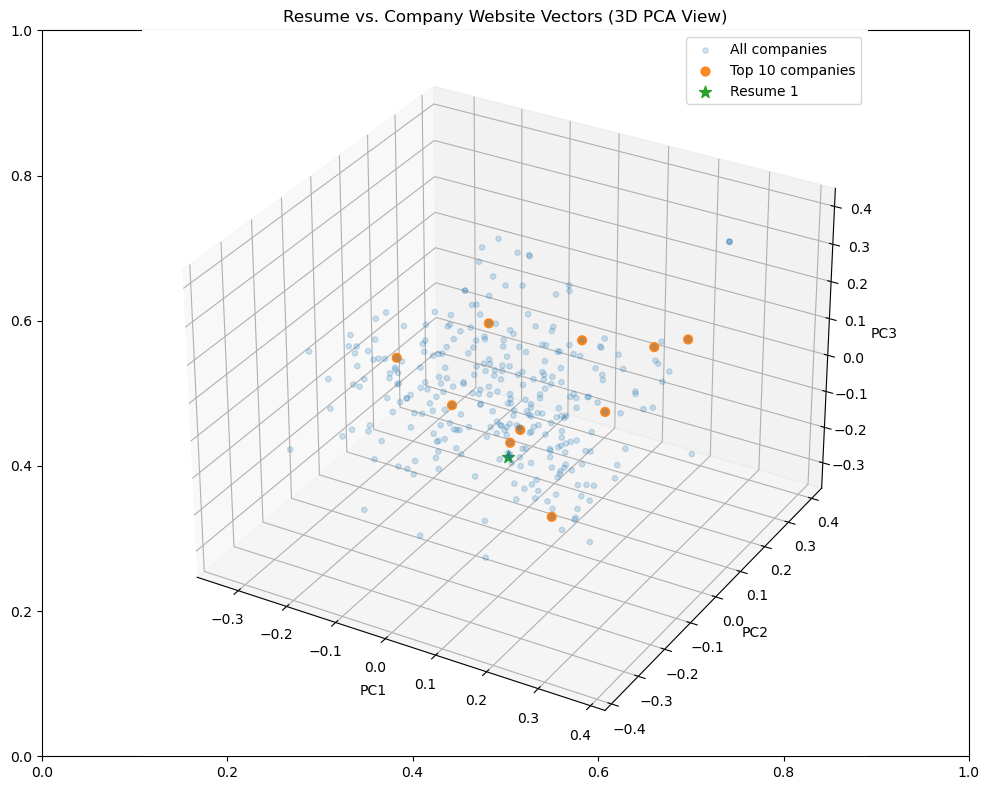

,osm_id,name,city,lat,lon,website,email,phone,similarity
0,11173785263,Load Bearing Wall Company - Structural Enginee...,Minneapolis,44.980049,-93.289282,https://loadbearingwallcompany.com/,contact@loadbearingwallcompany.com,+1 612-263-8622,0.464599
1,5288464644,On-Demand Group,Minneapolis,44.955279,-93.288366,https://www.ondemandgroup.com/,chosen-sprite@2x.png,+1-612-367-8101,0.394167
2,6262946713,MN ADOPT,Minneapolis,44.964067,-93.199579,https://www.mnadopt.org,info@fosteradoptmn.org,+1-612-861-7115,0.351584
3,6262953917,Move Minnesota,Minneapolis,44.963806,-93.199299,https://www.movemn.org,Rectangle-3@2x-700x416.jpg,+1-651-767-0298,0.338522
4,6410412074,Impact Hub,Minneapolis,44.973756,-93.225947,https://minneapolis.impacthub.net,host.msp@impacthub.net,+1 651 3182800,0.319851
5,5288574284,GearJunkie,Minneapolis,44.950537,-93.288337,https://gearjunkie.com/,contact@gearjunkie.com,0106273489,0.317785
6,8857921390,Bicycle Alliance of Minnesota,Minneapolis,44.934588,-93.223964,https://www.bikemn.org/,info@bikemn.org,(202010-2019,0.312079
7,88315820,Hope Lodge American Cancer Society,Minneapolis,44.972966,-93.221326,https://www.cancer.org/,Legal@wearemoore.com,+1-612-379-6352,0.309213
8,9804279975,Professional Data Analysts,Minneapolis,45.007660,-93.254745,https://www.pdastats.com/,PDAinfo@pdastats.com,0521717072,0.307350
9,7173830869,Malmberg Projects,Minneapolis,44.966886,-93.197461,https://www.malmbergprojects.com/,user@domain.com,10177478287,0.304079


In [128]:
top_10 = visualize_resume_vs_companies(user_id="tyler_wacker_minneapolis", 
                                       resume_id=1, 
                                       top_k=10)
top_10

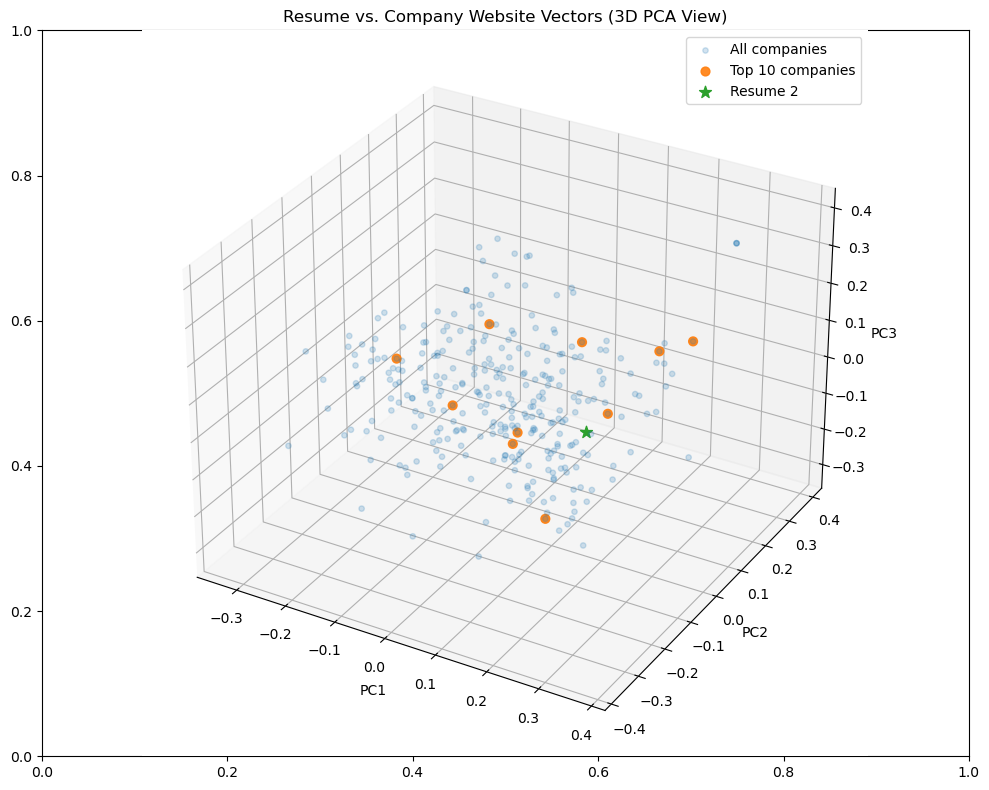

,osm_id,name,city,lat,lon,website,email,phone,similarity
0,6456665455,Forecast Public Art,Minneapolis,44.961745,-93.196129,https://forecastpublicart.org/,ads@forecastpublicart.org,+1-651-641-1128,0.421526
1,6273229352,"Triangle Park Creative, Inc.",Minneapolis,44.963696,-93.197813,https://www.triangleparkcreative.com,dan@triangleparkcreative.com,+1-612-436-9177,0.318482
2,11173785263,Load Bearing Wall Company - Structural Enginee...,Minneapolis,44.980049,-93.289282,https://loadbearingwallcompany.com/,contact@loadbearingwallcompany.com,+1 612-263-8622,0.300172
3,6267046573,"All City Elevator, Inc.",Minneapolis,44.970935,-93.193573,https://www.allcityelevator.com,info@allcityelevator.com,+1-651-646-5600,0.280969
4,403118290,Sylvia I. Anderson Realty,Minneapolis,44.948157,-93.214233,https://andersonrealtymn.com/,mikesmithrealty@gmail.com,+1-612-886-3603,0.278021
5,12875293763,Wise Design & Remodel,Minneapolis,44.969836,-93.195193,https://www.wisedesignremodel.com/,info@wisedesignremodel.com,+1-612-849-2515,0.268520
6,6273229358,Monarch Bus Service,Minneapolis,44.960688,-93.200670,https://www.monarchbusservice.com,bkboaz@minnesotacoaches.com,+1-651-288-3055,0.263494
7,6429527898,Metropolis Design Group,Minneapolis,44.905236,-93.287427,https://www.metropolisdesigngroup.com/,2062d0a4929b45348643784b5cb39c36@sentry.wixpre...,+1-612-760-2569,0.263080
8,6433139160,Learning Abroad Center,Minneapolis,44.971695,-93.243831,https://umabroad.umn.edu,None,+1-612-626-9000,0.262364
9,5288464644,On-Demand Group,Minneapolis,44.955279,-93.288366,https://www.ondemandgroup.com/,chosen-sprite@2x.png,+1-612-367-8101,0.260775


In [117]:
top_10 = visualize_resume_vs_companies(user_id="tyler_wacker_minneapolis", 
                                       resume_id=2, 
                                       top_k=10)
top_10

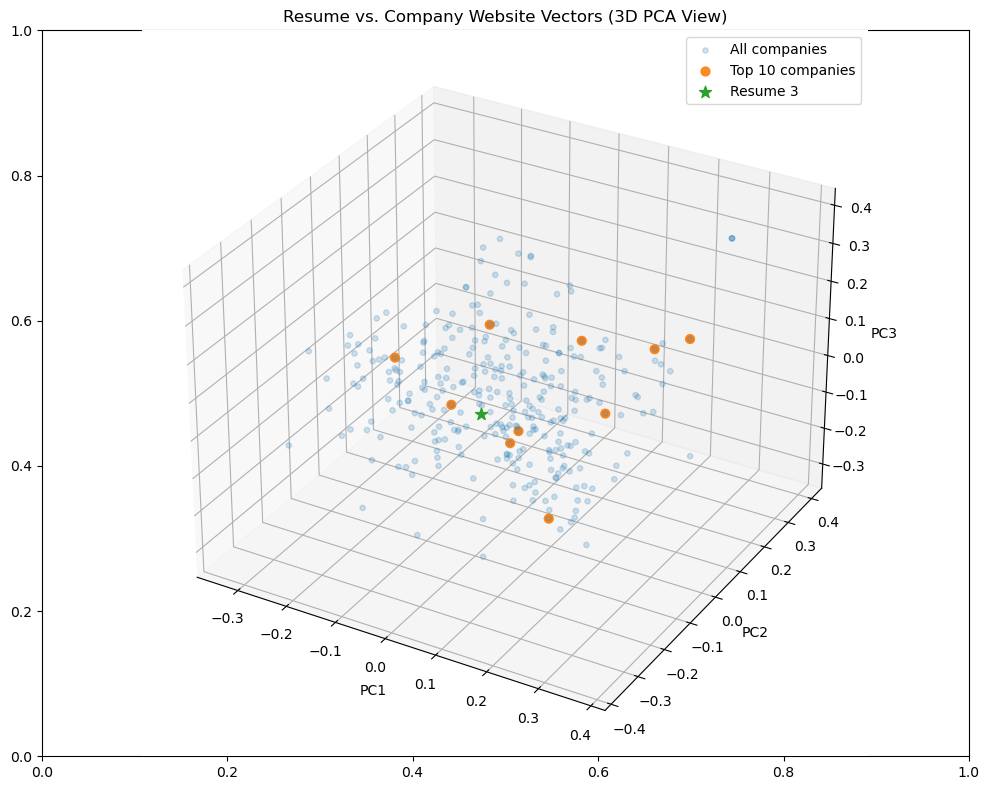

,osm_id,name,city,lat,lon,website,email,phone,similarity
0,6423573751,Code42,Minneapolis,44.981166,-93.265809,https://code42.com,support@code42.com,+1-612-333-4242,0.376152
1,9804279975,Professional Data Analysts,Minneapolis,45.007660,-93.254745,https://www.pdastats.com/,PDAinfo@pdastats.com,0521717072,0.362158
2,5288464644,On-Demand Group,Minneapolis,44.955279,-93.288366,https://www.ondemandgroup.com/,chosen-sprite@2x.png,+1-612-367-8101,0.360631
3,13141654618,Ovative Group,Minneapolis,44.987895,-93.277990,https://ovative.com/,None,+1 612-886-1010,0.354749
4,6275543775,Stonebridge Capital Advisors,Minneapolis,44.965289,-93.204264,https://stonebridgecap.com/,amarsh@stonebridegcap.com,+1-651-251-1000,0.349017
5,11173785263,Load Bearing Wall Company - Structural Enginee...,Minneapolis,44.980049,-93.289282,https://loadbearingwallcompany.com/,contact@loadbearingwallcompany.com,+1 612-263-8622,0.337843
6,11283726032,World Wide Technology (WWT),Minneapolis,44.968193,-93.344270,https://wwt.com/,Rebecca.Morrison@wwt.com,+1-952-229-0025,0.336459
7,2071078928,Exosite,Minneapolis,44.979840,-93.288413,https://exosite.com/,None,+1-612-353-2161,0.309776
8,11124443906,Premium Park Products,Minneapolis,44.983653,-93.343767,https://www.premiumparkproducts.com/,None,+15078816269,0.303674
9,6262946713,MN ADOPT,Minneapolis,44.964067,-93.199579,https://www.mnadopt.org,info@fosteradoptmn.org,+1-612-861-7115,0.294902


In [118]:
top_10 = visualize_resume_vs_companies(user_id="tyler_wacker_minneapolis", 
                                       resume_id=3, 
                                       top_k=10)
top_10

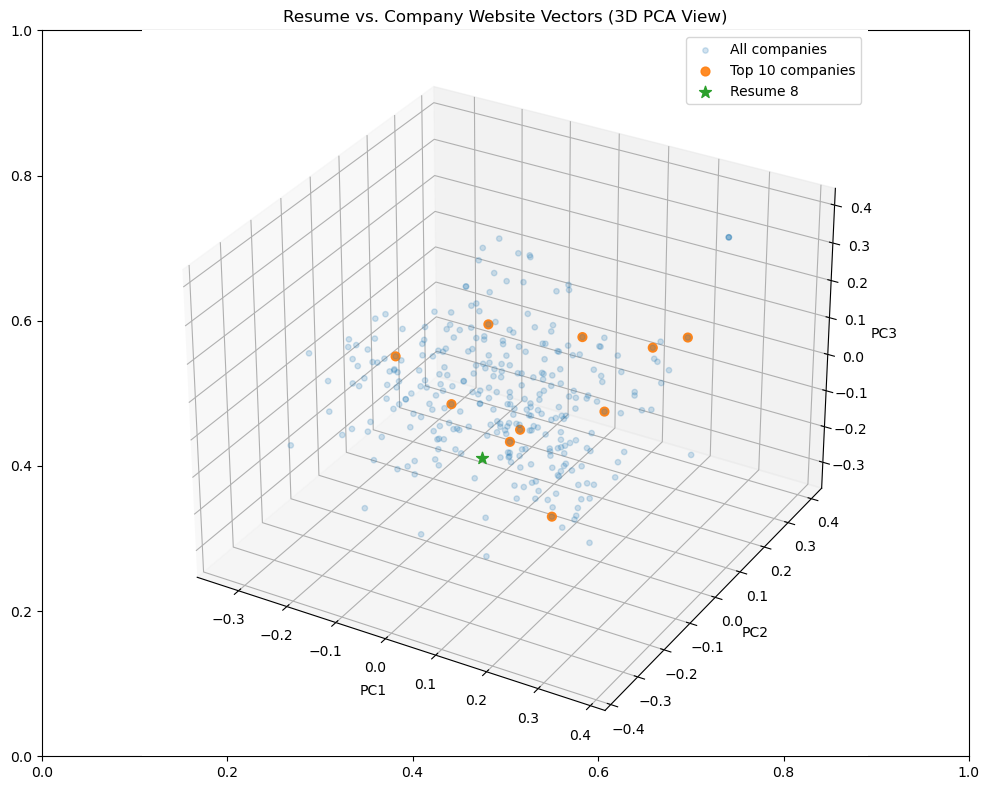

,osm_id,name,city,lat,lon,website,email,phone,similarity
0,6275543775,Stonebridge Capital Advisors,Minneapolis,44.965289,-93.204264,https://stonebridgecap.com/,amarsh@stonebridegcap.com,+1-651-251-1000,0.380505
1,9682325842,"Allodium Investment Consultants, LLC",Minneapolis,44.978789,-93.260461,https://allodium.com/,info@allodium.com,+1-612-230-3700,0.371862
2,9804279975,Professional Data Analysts,Minneapolis,45.007660,-93.254745,https://www.pdastats.com/,PDAinfo@pdastats.com,0521717072,0.355779
3,499158987,"Hagen, Christensen & McIlwain Architects",Minneapolis,44.926733,-93.246911,http://www.hcmarchitects.com/,Gutzman@hcmarchitects.com,+16129041332,0.346603
4,12036784663,Conflict Resolution Center,Minneapolis,44.961835,-93.291679,https://crcminnesota.org,duluth@crcminnesota.org,(218) 656-7497,0.335275
5,11173785263,Load Bearing Wall Company - Structural Enginee...,Minneapolis,44.980049,-93.289282,https://loadbearingwallcompany.com/,contact@loadbearingwallcompany.com,+1 612-263-8622,0.332110
6,6262953917,Move Minnesota,Minneapolis,44.963806,-93.199299,https://www.movemn.org,Rectangle-3@2x-700x416.jpg,+1-651-767-0298,0.330681
7,6410412074,Impact Hub,Minneapolis,44.973756,-93.225947,https://minneapolis.impacthub.net,host.msp@impacthub.net,+1 651 3182800,0.329101
8,6262946713,MN ADOPT,Minneapolis,44.964067,-93.199579,https://www.mnadopt.org,info@fosteradoptmn.org,+1-612-861-7115,0.324580
9,3144855834,International student and scholar service (ISSS),Minneapolis,44.971644,-93.244129,https://isss.umn.edu,None,+1-612-626-7100,0.322665


In [119]:
top_10 = visualize_resume_vs_companies(user_id="tyler_wacker_minneapolis", 
                                       resume_id=8, 
                                       top_k=10)
top_10

# 5.0 Project Discussion

The goals as outlined within this project's conception were to:

...answer relevant questions asked during most job searches, such as:

- What jobs are available near me?
- Are certain business types more prevalent in certain locations?
- How can I reach businesses near me?

As I continue to develop this program, I think that we've established sufficient information to provide answers to some of these concerns. This notebook developed a scalable solution that can be applied in many different locals for scraping contact information and business listings from the internet. This provides users with the ability to reach local businesses and conduct outreach regarding their open positions.

This notebook also developed important first steps in comparing users to business listings. I attempted to utilize a HashingVectorizer to quickly compare resumes and companies, but there we significant pitfalls in using this analytical approach. Due to occassional use of rare terms with little semantic value in both resume and company text data, significant similarity was established between non-semantically related users/companies. 

For example, consider Resume 1. This user's resume was intended to be tailored towards the educational industry and teaching positions that may be available. Because they used the word 'impact' in their resume, however, many of the returned listings have something to do with engineering, construction, or design. 

## 5.1 Future Directions

There are three main concerns I have with taking this project to market:
1. Company Data Input
2. UI/UX Design
3. Scope of Analytics Solutions

To perform as a product instead of a project, this notebook needs to accomodate more than just 1 source of company information. Therefore, it will be important to build webscrapers that are able to gather from other sources such as Google Maps, Craigslist, or Facebook. The current SQL schema is scalable, and this concern should be managable, seeing as much concern was directed towards this idea throughout the project.

Secondly, the UI/UX of this project is completely in the dirt. If this data pipeline were to be handled by a technically capable recruiter, (and I don't mean a recruiter who's only good at their job on paper) we can assume that they wouldn't need to develop these features. Unfortunately, as a widely available product, you would want your UI/UX design to reflect this. I need to develop a webapplication that can contain the functions outlined within this project, display the analytical conclusions, and make sales offerings that become appealing as information is provided. 

Lastly, I believe that since my data is currently collected in efficacious manner, I need to refine the analytical approaches I conduct with the data. Prior to comparing the vectors, there is an opportunity to use KMEANS to cluster resumes/companies based on industry. This may result in more relevant 'similarity' matches being conducted. For similar reasons, it makes sense to refine the vectorization model to something that is more insulated against non-semantic vocabulary. A TFIDF vectorization strategy would need to be trained on my dataset, but it may present more expected results.

If you have any questions regarding the material presented within this notebook, send me an email @ tjwac27@gmail.com.